In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For} example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import re
import string
import pickle

%matplotlib inline

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import tensorflow as tf 
import tensorflow.keras.preprocessing
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns 

# Loading the Data

In [3]:
true = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')
fake = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')



# Exploring Data

Text(0, 0.5, '# of News Articles')

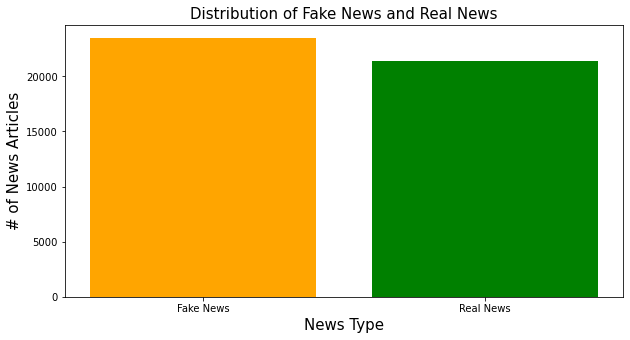

In [4]:
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake), color='orange')
plt.bar('Real News', len(true), color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('# of News Articles', size=15)

In [5]:
true['category'] = 1
fake['category'] = 0

news = pd.concat([true,fake], ignore_index=True)

In [6]:
#Missing values
news.isnull().sum()

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [7]:
news.columns

Index(['title', 'text', 'subject', 'date', 'category'], dtype='object')

# Data Preprocessing 

In [8]:
#Concatinating the title and text to produce one string 
news['text'] = news['text'] + " " + news['title']

#Removing the date, subject and title to decrease the model's bias
news.drop(['date','subject','title'], axis=1, inplace=True)


## Preparing the string
* Casing
* Noise Removal
* Tokenization
* Stopword Removal
* Text Normalization

In [9]:
def clean_text(text):
    
    #convert all text to lower case
    text = text.lower()
    
    #remove any URL
    text = re.sub('https://\S+|www\.\S+', '', text, flags=re.MULTILINE)
    
    #remove punctuation
    text = text.translate(str.maketrans("", "",string.punctuation))
    
    #remove stopwords
    text_tokens = word_tokenize(text)
    filtered_words = [word for word in text_tokens if word not in stopwords.words('english')]
    
    #stemming
    ps = PorterStemmer()
    stemmed_words = [ps.stem(word) for word in filtered_words]
    
    #lemmatizing
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(word, pos='a') for word in stemmed_words]
    
    return " ".join(filtered_words)


    

In [10]:
#Text cleaning
news['text'] = news['text'].apply(clean_text)


In [11]:
#Saving the cleaned dataframe, to reduce the time of preprocessing for several runs
news.to_pickle("corpus.pkl")

In [12]:
#news = pd.read_pickle("./corpus.pkl")

In [13]:
#tokenization parameters
max_len = 500
max_features = 10000

In [14]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(news['text'])
sequence = tokenizer.texts_to_sequences(news['text'])


In [15]:
x = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen = max_len)

In [16]:
#Data splitting
x_train_val,x_test,y_train_val,y_test = train_test_split(x,news.category,test_size=0.2,random_state = 0)

x_train,x_val,y_train,y_val = train_test_split(x_train_val,y_train_val,test_size=0.25,random_state = 0)

In [17]:
#Defining Neural Network
model = Sequential()

#Embeddidng layer
model.add(Embedding(max_features, 32))

#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))

#Dense layer 
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

#Model Compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         82432     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 453,953
Trainable params: 453,953
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(x_train, y_train, epochs = 5, validation_data= (x_val, y_val))

Epoch 1/5
842/842 [==============================] - 1301s 2s/step - loss: 0.0995 - accuracy: 0.9582 - val_loss: 0.0380 - val_accuracy: 0.9870
Epoch 2/5
842/842 [==============================] - 1323s 2s/step - loss: 0.0192 - accuracy: 0.9938 - val_loss: 0.0300 - val_accuracy: 0.9905
Epoch 3/5
842/842 [==============================] - 1341s 2s/step - loss: 0.0115 - accuracy: 0.9961 - val_loss: 0.0329 - val_accuracy: 0.9884
Epoch 4/5
842/842 [==============================] - 1320s 2s/step - loss: 0.0041 - accuracy: 0.9986 - val_loss: 0.0242 - val_accuracy: 0.9930
Epoch 5/5
842/842 [==============================] - 1350s 2s/step - loss: 0.0075 - accuracy: 0.9977 - val_loss: 0.0329 - val_accuracy: 0.9899


In [19]:
y_pred=model.predict_classes(x_test)

results = model.evaluate(x_test, y_test)

281/281 [==============================] - 43s 153ms/step - loss: 0.0362 - accuracy: 0.9892


In [20]:
print("test loss: {:.3f}, test acc: {:.3f}%".format( results[0],results[1]*100 ))

test loss: 0.036, test acc: 98.920%


In [21]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[4634,   36],
       [  61, 4249]])

Text(69.0, 0.5, 'Actual')

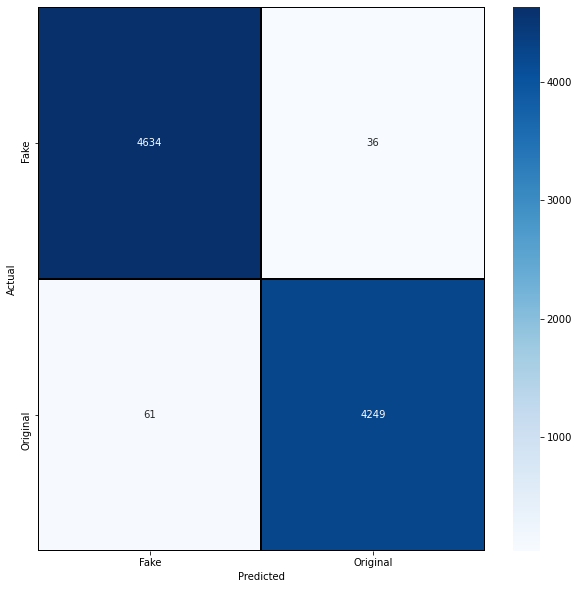

In [22]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")